In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import pandas as pd
from pathlib import Path
from utils import *
from models import *
from ucr import *
from inception import *
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import fastai
from fastai.vision import *

In [3]:
DATAPATH = Path.cwd()/'Univariate_arff'

In [4]:
sorted(list(DATAPATH.iterdir()))

[PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ACSF1'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Adiac'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteX'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteY'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteZ'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ArrowHead'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BME'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Beef'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BeetleFly'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BirdChicken'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/CBF'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/C

In [5]:
task = 'StarLightCurves'
df_train, df_test = load_df(DATAPATH, task)

Loading files from: /home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/StarLightCurves


In [6]:
num_classes = df_train.target.nunique(); num_classes

3

# DL

In [7]:
X_train, y_train, X_test, y_test = process_dfs(df_train, df_test, True); X_train.shape

(1000, 1, 1024)

## Resnet 1D

In [8]:
# model = create_resnet(1, num_classes, conv_sizes=[64, 128, 256], stride=1).cuda()

In [9]:
# model = create_inception(1, num_classes).cuda()

In [10]:
model = create_mlp(X_train[0].shape[-1], num_classes).cuda()

In [11]:
# model = create_fcn(1, num_classes)

In [12]:
model = model.cuda()

## LBFGS

In [13]:
from lbfgs import *

In [14]:
optimizer = FullBatchLBFGS(model.parameters(), lr=6, history_size=10, line_search='Wolfe', debug=True)
loss_fn = CrossEntropyFlat()

In [15]:
X_train.shape, y_train.shape, y_train.dtype

((1000, 1, 1024), (1000,), dtype('float64'))

In [16]:
#%% Main training loop
X_train = torch.Tensor(X_train).float().cuda()
y_train = torch.Tensor(y_train).long().cuda()

X_test = torch.Tensor(X_test).float().cuda()
y_test = torch.Tensor(y_test).long().cuda()

no_samples = X_train.shape[0]

In [17]:
# Do the forward pass, then compute the accuracy
accfun   = lambda op, y: accuracy(op, y)
opfun = lambda X: model(X)

In [18]:
def stats(model,X_test, y_test):
    y_pred_test = model(X_test)
    return error_rate(y_pred_test, y_test).data.item()

In [19]:
# main loop
max_iter=100

for n_iter in progress_bar(range(max_iter)):

    # training mode
    model.train()

    # define closure for line search
    def closure():
        optimizer.zero_grad()
        y_pred = model(X_train) 
        loss = loss_fn(y_pred, y_train)
        return loss

    # perform line search step
    if n_iter==0: options = {'closure': closure}#, 'current_loss': obj}
    else:  {'closure': closure, 'current_loss': obj}
    obj, grad, lr, _,_,_, _, _= optimizer.step(options)
    
    model.eval()

    print(f'{n_iter} - train_loss: {obj.data.item()}, error_rate: {stats(model, X_test, y_test)}, lr: {lr}')

Not a descent direction!
0 - train_loss: 1.3112421035766602, error_rate: 0.801481306552887, lr: 1.2000000000000002
Curvature pair skipped due to failed criterion
1 - train_loss: 1.1363433599472046, error_rate: 0.42277806997299194, lr: 0.3495715315901232
2 - train_loss: 0.653957188129425, error_rate: 0.42277806997299194, lr: 0.24039365054042042
3 - train_loss: 0.43803003430366516, error_rate: 0.42156386375427246, lr: 2.6483375266768334
4 - train_loss: 0.4483322203159332, error_rate: 0.26311320066452026, lr: 2.2054987143391744
5 - train_loss: 0.29575061798095703, error_rate: 0.20058280229568481, lr: 1.6711332609549823
6 - train_loss: 0.2928984463214874, error_rate: 0.16257894039154053, lr: 2.9361961694867422
7 - train_loss: 0.28041404485702515, error_rate: 0.15225839614868164, lr: 2.061516187983007
8 - train_loss: 0.27060917019844055, error_rate: 0.1472802758216858, lr: 2.461389483990182
9 - train_loss: 0.2571185529232025, error_rate: 0.1457018256187439, lr: 2.0835428534206635
10 - train

88 - train_loss: 0.11151853203773499, error_rate: 0.057795047760009766, lr: 0
Line search failed; curvature pair update skipped
89 - train_loss: 0.11615397781133652, error_rate: 0.052452683448791504, lr: 0.43504411888171285
90 - train_loss: 0.11168014258146286, error_rate: 0.05730938911437988, lr: 0.6471241973168671
91 - train_loss: 0.12168976664543152, error_rate: 0.06483733654022217, lr: 6
92 - train_loss: 0.10248839110136032, error_rate: 0.055002450942993164, lr: 2.2798009815056752
93 - train_loss: 0.1007026955485344, error_rate: 0.05475962162017822, lr: 0.3695373681346839
94 - train_loss: 0.10724762827157974, error_rate: 0.05973774194717407, lr: 1.621039464250086
95 - train_loss: 0.10839884728193283, error_rate: 0.0596163272857666, lr: 0.7978958876968055
96 - train_loss: 0.1205783486366272, error_rate: 0.058645009994506836, lr: 1.0842597892806483
97 - train_loss: 0.08783353120088577, error_rate: 0.05645948648452759, lr: 1.3987497849634425
98 - train_loss: 0.11080218851566315, error

## Eval

In [20]:
model.eval()
p = model(X_test)

In [21]:
error_rate(p, y_test)

tensor(0.0618, device='cuda:0')

In [22]:
def get_cm(p, t): return confusion_matrix(t, p.softmax(dim=1).argmax(1))

Confusion Matrix

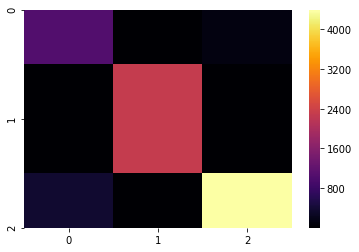

In [23]:
sns.heatmap(get_cm(p,y_test), cmap='inferno')